# Submission score ... (PCA)

A grans trets:


In [20]:
# Import essentials
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

The train values, train labels and test values are in different datasets, **we will load evrything and merge it together in the same dataframe (with label = NaN for the test)**. In that way, all the treatment (means, outliers, ...) we do would be considering the entire dataset

In [21]:
# load the csv
train_values_df = pd.read_csv('train_values.csv') # Load the `train` file
train_labels_df = pd.read_csv('train_labels.csv') # Load the `train` file
test_values_df = pd.read_csv('test_values.csv') # Load the `train` file
test_ids = test_values_df['patient_id']

de l'analisi dels histogrames hem vist que hi havien dues variables amb algunes diferencies entre train i test set:
1. serum_cholesterol_mg_per_dl
2. oldpeak_eq_st_depression

In [22]:
train_values_df[train_values_df['serum_cholesterol_mg_per_dl']>500]

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
60,rv6siv,2,reversible_defect,115,3,0,0,2,564,1.6,0,67,160,0


In [23]:
train_values_df[train_values_df['oldpeak_eq_st_depression'] > 5]

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
140,noxsnw,3,reversible_defect,140,4,0,0,0,217,5.6,1,55,111,1
162,usnkhx,3,reversible_defect,160,4,3,0,2,164,6.2,0,62,145,0


#### Provem d'eliminar pacients que te outlier amb serum de colesterol
hauriem de mirar si eliminant el de oldpeak tb millorem algo

In [24]:
train_values_df=train_values_df.drop([60])
train_labels_df=train_labels_df.drop([60])

merge and concat the dataframes in one (NaNs for the test label)

In [25]:
heart_df= pd.concat([pd.merge(train_values_df, train_labels_df, on='patient_id'), test_values_df], sort=False)
heart_df.head()

#store the original dimensions
len_train=train_values_df.shape[0]
len_test=test_values_df.shape[0]

Curiositat per l'edat, es veuen distribucions molt diferents?

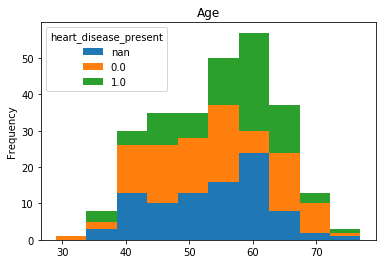

In [26]:
heart_df.pivot(columns='heart_disease_present').age.plot(kind = 'hist', bins=10, stacked=True)
plt.title('Age')
plt.show()

#### Pre-Processing: estandaritzem utilitzant el MinMaxScaler

In [27]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

heart_df['serum_cholesterol_mg_per_dl'] = min_max_scaler.fit_transform( np.array(heart_df['serum_cholesterol_mg_per_dl'].values).reshape(-1,1))
heart_df['max_heart_rate_achieved'] = min_max_scaler.fit_transform( np.array(heart_df['max_heart_rate_achieved'].values).reshape(-1,1))
heart_df['oldpeak_eq_st_depression'] = min_max_scaler.fit_transform( np.array(heart_df['oldpeak_eq_st_depression'].values).reshape(-1,1))
heart_df['resting_blood_pressure'] = min_max_scaler.fit_transform( np.array(heart_df['resting_blood_pressure'].values).reshape(-1,1))

#### Categoritzem les edats
Podriem probar de fer un MinMAx tb...

In [28]:
# en aquest bloc definim una columna categoritzant les edats
bins= [20,30,40,50,60,70,80]
labels = ['20-29','30-39','40-49','50-59','60-69','70-79']
heart_df['AgeGroup'] = pd.cut(heart_df['age'], bins=bins, labels=labels, right=False)
del heart_df['age']
pd.value_counts(heart_df['AgeGroup'])

50-59    107
60-69     73
40-49     67
30-39     11
70-79     10
20-29      1
Name: AgeGroup, dtype: int64

##### utilitzem funcio Dummies per resta variables i la nova d'age

In [29]:
heart_df_D=pd.get_dummies(heart_df, columns=['AgeGroup','thal','slope_of_peak_exercise_st_segment','chest_pain_type','num_major_vessels','resting_ekg_results','exercise_induced_angina','fasting_blood_sugar_gt_120_mg_per_dl'])
heart_df_D.head()

,patient_id,resting_blood_pressure,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,max_heart_rate_achieved,heart_disease_present,AgeGroup_20-29,AgeGroup_30-39,AgeGroup_40-49,...,num_major_vessels_1,num_major_vessels_2,num_major_vessels_3,resting_ekg_results_0,resting_ekg_results_1,resting_ekg_results_2,exercise_induced_angina_0,exercise_induced_angina_1,fasting_blood_sugar_gt_120_mg_per_dl_0,fasting_blood_sugar_gt_120_mg_per_dl_1
0,0z64un,0.320755,0.625430,0.000000,1,0.755725,0.0,0,0,1,...,0,0,0,0,0,1,1,0,1,0
1,ryoo3j,0.150943,0.302405,0.258065,0,0.664122,0.0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
2,yt1s1x,0.292453,0.611684,0.000000,1,0.694656,1.0,0,0,0,...,0,0,1,0,0,1,0,1,1,0
3,l2xjde,0.547170,0.333333,0.000000,1,0.839695,1.0,0,0,1,...,0,0,0,1,0,0,1,0,1,0
4,oyt4ek,0.792453,0.494845,0.677419,1,0.564885,0.0,0,0,0,...,0,0,0,0,0,1,1,0,1,0


#### El primer sera veure el Bagging classifier si funciona be o no, tal qual

In [30]:
# seleccionem les features que utilitzarem, important eliminar patient_id i heart_disease
features_D = heart_df_D.columns.tolist()
features_D.remove('heart_disease_present')
features_D.remove('patient_id')

# load data
df_Heart_train=heart_df_D[:len_train]
df_Heart_test=heart_df_D[len_train:]
X=df_Heart_train[features_D]
y=df_Heart_train['heart_disease_present']

In [34]:
!pip install lightgbm

c:\users\pablo\anaconda3\lib\site-packages\pip\_internal\req\req_install.py:391: UserWarning: Unbuilt egg for motu-client [unknown version] (c:\users\pablo\anaconda3\lib\site-packages)
  self.satisfied_by = pkg_resources.get_distribution(str(no_marker))
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [44]:
# k-fold cross validation evaluation of xgboost model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.linear_model import LinearRegression
import lightgbm as lgb

d_train = lgb.Dataset(X, label=y)

params = {}
params['max_bin'] = 10
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'l1'          # or 'mae'
params['sub_feature'] = 0.50      # feature_fraction 
params['bagging_fraction'] = 0.85 # sub_row
params['bagging_freq'] = 40
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 500         # min_data_in_leaf
params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
params['verbose'] = 0

cv_results = lgb.cv(params, d_train,  
                    verbose_eval=10, early_stopping_rounds=40)
# CV model
#model = XGBClassifier(colsample_bytree=0.1,n_estimators=500, reg_lambda=1, learning_rate=0.08, min_child_weight = 2, max_depth = 8, gamma=2, subsample=.2,scale_pos_weight = 1, eval_metric='logloss',reg_alpha=0.00001)
#model= lgb.LGBMModel()
#kfold = KFold(n_splits=10, random_state=7)

#results = cross_val_score(model, X, y, cv=kfold, scoring='neg_log_loss', )
#print("Log loss: %.2f%% (%.2f%%)" % (results.mean(), results.std()))

print('Current parameters:\n', params)
print('\nBest num_boost_round:', len(cv_results['l1-mean']))
print('Best CV score:', cv_results['l1-mean'][-1])

[10]	cv_agg's l1: 0.541787 + 0.00422688
[20]	cv_agg's l1: 0.541787 + 0.00422688
[30]	cv_agg's l1: 0.541787 + 0.00422688
[40]	cv_agg's l1: 0.541787 + 0.00422688
Current parameters:
 {'max_bin': 10, 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'l1', 'sub_feature': 0.5, 'bagging_fraction': 0.85, 'bagging_freq': 40, 'num_leaves': 512, 'min_data': 500, 'min_hessian': 0.05, 'verbose': 0}

Best num_boost_round: 1
Best CV score: 0.5417871017871017


In [ ]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
lgb.train(X_train,y_train)
lgb.

In [ ]:
evaluation_results = {}
clf = lgbm.train(train_set=train_data,
                 params=lgbm_params,
                 valid_sets=[train_data, test_data], 
                 valid_names=['Train', 'Test'],
                 evals_result=evaluation_results,
                 num_boost_round=500,
                 early_stopping_rounds=100,
                 verbose_eval=20
                )
optimum_boost_rounds = clf.best_iteration

Els reusltats no son dolents, amb un log loss al voltant de 0.43.... pero hem de millorar!!!

#### Feature Importance using Gradient Boosting
Fem un primer test de com es tracta en el Gradient Boosting el Feature Importance.
Basicament apliquem el model sobre les dades, i despres utilitzam el plot_importance del mateix xgboost per veure classificacio features mes important.
L'analisi no es senzill, i de fet pots veure diferents tipus d'importancies (no ho acabo de pillar). el mes interessant es que aixo ens permetra seleccionar features en funcio d'un threshold, i aixo ens permetrà veure resultast de models diferents optimitzant les features seleccionades

In [ ]:
# plot feature importance using built-in function
#!pip install xgboost

# fit model no training data
model.fit(X, y)

# plot feature importance

_, ax = plt.subplots(1, 1, figsize=(12, 12))
plot_importance(model, ax=ax, importance_type='gain',max_num_features=34);
plt.show()

Aqui ja es veuen coses interessants, pero es dificil triar de forma manual a partir de quin fetaure tindrem millors resultats.
utilitzarem eines del model per fer aquesta seleccio...

#### Aqui fem el Preprocessing i generem arrays que farem servir pel model despres

In [ ]:
import sklearn.preprocessing as preproc
from sklearn.decomposition import PCA
# Create pairwise interaction features, skipping the constant bias term
#X2_train = preproc.PolynomialFeatures(include_bias=False).fit_transform(X)
#X2b_train = preproc.PolynomialFeatures(include_bias=True).fit_transform(X)
#X3_train = preproc.PolynomialFeatures(interaction_only=True, degree=2).fit_transform(X)

print (X.shape)
#print (X2_train.shape)
#print (X3_train.shape)

In [ ]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, log_loss


for i in range(1,30,1):
    pca = PCA(i)
    projected = pca.fit_transform(X)
    projected_X2_train = preproc.PolynomialFeatures(include_bias=False).fit_transform(projected)
    
    X_train, X_test, y_train, y_test = train_test_split(projected, y, test_size=0.2, random_state=10)
    X2_train, X2_test, y2_train, y2_test = train_test_split(projected_X2_train, y, test_size=0.2, random_state=10)

    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    model.fit(X2_train,y2_train)
    y2_pred = model.predict(X2_test)
    y2_proba = model.predict_proba(X2_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracy2 = accuracy_score(y2_test, y2_pred)
    print('number of PCAs: ',i, 'and accuracy: ',accuracy )
    print('number of PCAs: ',i, 'and accuracy: ',accuracy2 )

    logi = log_loss(y_test, y_proba)
    logi2 = log_loss(y2_test, y2_proba)
    print('number of PCAs: ',i, 'and log loss: ',logi)
    print('number of PCAs: ',i, 'and log loss: ',logi2,'\n' )

# La submission 9 es aquesta:

X_total=heart_df_D[features_D]
print (X_total.shape)

X2_total = preproc.PolynomialFeatures(include_bias=False).fit_transform(X_total)

pca = PCA(2)
projected = pca.fit_transform(X2_total)

projected_train=projected[:len_train]
projected_test=projected[len_train:]

print (projected_train.shape)
print (projected_test.shape)


# model fit
model.fit(projected_train,y)

# eval model
y_pred = model.predict(projected_test)
y_proba = model.predict_proba(projected_test)

In [ ]:
# La submission 9b es aquesta:
pca = PCA(2)
X_total=heart_df_D[features_D]
projected = pca.fit_transform(X_total)
print (projected.shape)

projected_train=projected[:len_train]
projected_test=projected[len_train:]

print (projected_train.shape)
print (projected_test.shape)

# model fit
model.fit(projected_train,y)

# eval model
y_pred = model.predict(projected_test)
y_proba = model.predict_proba(projected_test)

#### preparem submission

In [ ]:
targets = train_labels_df['heart_disease_present'].unique()
predictions = pd.DataFrame()
# Record each prediction for each class as a separate column
for j in range(len(targets)):
    predictions[j] = y_proba[:,j]
    
# Add needed information for predictions 
predictions['patient_id'] = test_ids

# Find the class and associated probability
predictions['heart_disease_present'] = predictions[targets].idxmax(axis = 1)
predictions['confidence'] = predictions[targets].max(axis = 1)

submission= predictions[['patient_id',1]]
submission.columns = ['patient_id','heart_disease_present']

In [ ]:
submission.to_csv('Pablo_submission9b.csv',index=False)